# Proyecto

## Práctica 3: clustering

#### 3.-Aplicar K-means al resultado obtenido en el apartado 3 de la práctica 2. En este punto se tomará como referencia el notebook https://formacion.uam.es/mod/resource/view.php?id=75516.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import random 
import math
from time import time
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
# carga de datos del fichero horario original
df_bike = pd.read_csv('df_bike_final.csv', sep=',')
df_bike = df_bike.iloc[:,1:]

print("num_rows: %d\tColumnas: %d\n" % (df_bike.shape[0], df_bike.shape[1]) )
print("Columnas:\n", list(df_bike.columns))

num_rows: 17379	Columnas: 15

Columnas:
 ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'cnt', 'season_weather', 'day']


In [4]:
# Lo primero que vamos a hacer es recuperar la variable registered a partir de restar cnt y casual
def f(row):
    return (row['cnt']-row['casual'])

df_bike['registered'] = df_bike.apply(f, axis=1)

In [5]:
# Se observa que el valor máximo de 'cnt' es cercano a 1000, así que vamos a formar una nueva variable que cree a 
# partir de 'cnt' 4 clases distintas según intervalos de valores.
def f(row):
    if row["cnt"] < 250:
        return 0
    elif row["cnt"] >= 250 and row["cnt"] < 500:
        return 1
    elif row["cnt"] >= 500 and row["cnt"] < 750:
        return 2  
    elif row["cnt"] >= 750 and row["cnt"] < 1000:
        return 3
    print(row)

df_bike['cnt_class'] = df_bike.apply(f, axis=1)

In [6]:
# dividimos variable target y predictoras. La variable target sería la cnt_class
vars_bike = list(df_bike.columns[:-1])
target_bike = df_bike.columns[-1]
print(vars_bike)
print(target_bike)

['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'casual', 'cnt', 'season_weather', 'day', 'registered']
cnt_class


In [7]:
# separación de datos
X = df_bike
y = df_bike[target_bike]
nombres_atributos = list(df_bike.columns)

In [8]:
# cálculo de componentes principales con PCA, ejercicio de la práctica anterior.
X_std = StandardScaler().fit_transform(X)
pca = PCA()
X_pca = pca.fit_transform(X_std)

print()
print('-- Estadísticas de los datos proyectados en las componentes principales --')
print()

for i in range(X_pca.shape[1]):
    print("* Datos en componente principal", i+1, ":")
    print("  - Media    :", X_pca[:,i].mean().round(3))
    print("  - Varianza :", X_pca[:,i].var(ddof=1).round(3))
    print("  - Autovalor:", pca.explained_variance_[i].round(3))
    print("  - Varianza explicada:", (100*pca.explained_variance_ratio_[i]).round(3), "%")
    print()


-- Estadísticas de los datos proyectados en las componentes principales --

* Datos en componente principal 1 :
  - Media    : -0.0
  - Varianza : 4.146
  - Autovalor: 4.146
  - Varianza explicada: 24.386 %

* Datos en componente principal 2 :
  - Media    : -0.0
  - Varianza : 2.869
  - Autovalor: 2.869
  - Varianza explicada: 16.875 %

* Datos en componente principal 3 :
  - Media    : 0.0
  - Varianza : 1.397
  - Autovalor: 1.397
  - Varianza explicada: 8.215 %

* Datos en componente principal 4 :
  - Media    : -0.0
  - Varianza : 1.207
  - Autovalor: 1.207
  - Varianza explicada: 7.101 %

* Datos en componente principal 5 :
  - Media    : 0.0
  - Varianza : 1.09
  - Autovalor: 1.09
  - Varianza explicada: 6.41 %

* Datos en componente principal 6 :
  - Media    : 0.0
  - Varianza : 1.007
  - Autovalor: 1.007
  - Varianza explicada: 5.922 %

* Datos en componente principal 7 :
  - Media    : -0.0
  - Varianza : 1.003
  - Autovalor: 1.003
  - Varianza explicada: 5.898 %

* Datos en

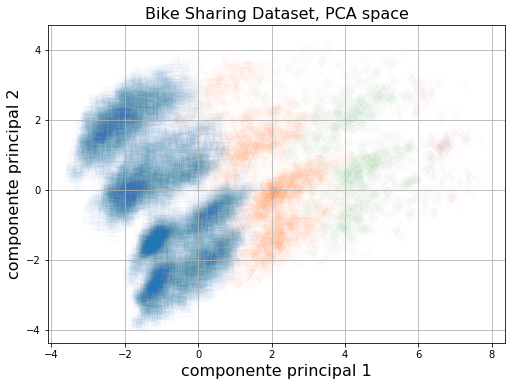

In [9]:
# graficamos el componente principal 1 y componente principal 2.
pc_x = 0
pc_y = 1

pcs_names = ['componente principal '+str(i+1) for i in range(pca.n_components_)]

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = ['s', 'v', 'o', 'd', 's', 'v', 'o', 'd', 's']

fig = plt.figure(figsize=(7,5))
for label,color,marker in zip(np.unique(y),colors,markers):
    inds = np.where(y == label)[0]
    plt.scatter(X_pca[inds, pc_x],
                X_pca[inds, pc_y],
                s = 60,
                c = color,
                marker = marker,
                alpha = 0.01,
                cmap='RdYlGn',
                label = label)

plt.grid(); plt.tight_layout()
plt.title('Bike Sharing Dataset, PCA space', fontsize=16)
plt.xlabel(pcs_names[pc_x], fontsize=16)
plt.ylabel(pcs_names[pc_y], fontsize=16)
plt.show()

In [13]:
# aplicamos K-means al PCA
LOOPS = 20
MAX_ITERATIONS = 30
INITIALIZE_CLUSTERS = 'k-means++'
CONVERGENCE_TOLERANCE = 0.001
NUM_THREADS = 8

In [14]:
kmeans_2 = KMeans(n_clusters=2,init='k-means++',max_iter=MAX_ITERATIONS)
kmeans_bike = kmeans_2.fit(X_pca)

In [15]:
# con el resultado de aplicar kmeans con 2 clusters obtenemos el atributo cluster
bikes_2 = kmeans_bike.fit_predict(X_pca)

# añadimos el atributo que identifica a cada registro en uno de los clusters
df_bike_kmeans = df_bike
df_bike_kmeans["Cluster"] = bikes_2
df_bike_kmeans.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
0,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,16,1,1,13.0,0,0
1,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,40,1,1,32.0,0,0
2,1,0,1,2,0,6,0,1,0.22,0.80,0.0,5,32,1,1,27.0,0,0
3,1,0,1,3,0,6,0,1,0.24,0.75,0.0,3,13,1,1,10.0,0,0
4,1,0,1,4,0,6,0,1,0.24,0.75,0.0,0,1,1,1,1.0,0,0


In [16]:
# ver los registros de cada cluster
pd.value_counts(df_bike_kmeans['Cluster'])

0    12425
1     4954
Name: Cluster, dtype: int64

In [17]:
# dataframe con los registros del cluster 0.
df_bike_0 = df_bike_kmeans[df_bike_kmeans['Cluster']==0]
df_bike_0.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
count,12425.000000,12425.000000,12425.000000,12425.000000,12425.00000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.000000,12425.0
mean,2.372475,0.429618,6.262616,10.296901,0.03002,2.983823,0.686439,1.483300,0.448140,0.663091,0.184951,15.643219,95.600644,6.973199,15.730141,79.957425,0.019396,0.0
std,1.155218,0.495041,3.661178,7.395438,0.17065,1.995886,0.463959,0.674767,0.182669,0.189006,0.124141,18.678395,78.521245,4.667072,8.791762,66.794356,0.137919,0.0
min,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,1.000000,0.000000,3.000000,4.000000,0.00000,1.000000,0.000000,1.000000,0.300000,0.520000,0.104500,2.000000,22.000000,2.000000,8.000000,19.000000,0.000000,0.0
50%,2.000000,0.000000,6.000000,9.000000,0.00000,3.000000,1.000000,1.000000,0.440000,0.680000,0.164200,8.000000,80.000000,6.000000,16.000000,68.000000,0.000000,0.0
75%,3.000000,1.000000,10.000000,16.000000,0.00000,5.000000,1.000000,2.000000,0.600000,0.820000,0.253700,23.000000,159.000000,11.000000,23.000000,129.000000,0.000000,0.0
max,4.000000,1.000000,12.000000,23.000000,1.00000,6.000000,1.000000,4.000000,0.960000,1.000000,0.850700,142.000000,405.000000,15.000000,31.000000,393.000000,1.000000,0.0


In [18]:
# dataframe con los registros del cluster 1.
df_bike_1 = df_bike_kmeans[df_bike_kmeans['Cluster']==1]
df_bike_1.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
count,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.000000,4954.0
mean,2.825595,0.685507,7.227897,14.681470,0.025636,3.053492,0.673395,1.279774,0.619499,0.537283,0.203005,85.920468,424.877069,8.582156,15.566209,338.956601,1.282600,1.0
std,0.897010,0.464361,2.683361,4.099395,0.158062,2.029702,0.469019,0.512361,0.159353,0.172251,0.116721,64.206235,149.799468,3.666246,8.783172,145.666005,0.575838,0.0
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.100000,0.160000,0.000000,1.000000,170.000000,1.000000,1.000000,95.000000,0.000000,1.0
25%,2.000000,0.000000,5.000000,12.000000,0.000000,1.000000,0.000000,1.000000,0.500000,0.400000,0.134300,39.000000,307.000000,5.000000,8.000000,232.000000,1.000000,1.0
50%,3.000000,1.000000,7.000000,16.000000,0.000000,3.000000,1.000000,1.000000,0.640000,0.520000,0.194000,71.000000,385.000000,9.000000,15.000000,298.000000,1.000000,1.0
75%,4.000000,1.000000,9.000000,18.000000,0.000000,5.000000,1.000000,1.000000,0.740000,0.660000,0.283600,112.000000,505.000000,13.000000,23.000000,406.000000,2.000000,1.0
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,3.000000,1.000000,1.000000,0.850700,367.000000,977.000000,15.000000,31.000000,886.000000,3.000000,1.0


In [19]:
# agrupamos datos por Cluster y variable mes, para analizar la media de cada atributo por cluster y verlo a lo largo
# de los meses.
df_group = df_bike_kmeans.groupby(['Cluster', 'mnth']).mean()
df_group

season        yr         hr   holiday   weekday  workingday  \
Cluster mnth                                                                  
0       1     1.000000  0.490370  11.513333  0.052593  2.848889    0.632593   
        2     1.000000  0.479386  11.370251  0.033145  3.026677    0.675020   
        3     1.344371  0.412252  10.851821  0.000000  3.104305    0.735927   
        4     2.000000  0.411538  10.301923  0.031731  3.030769    0.676923   
        5     2.000000  0.417989   9.534392  0.029630  2.780952    0.718519   
        6     2.320285  0.411625   9.018980  0.000000  3.033215    0.748517   
        7     3.000000  0.409037   8.844233  0.024970  2.946492    0.678954   
        8     3.000000  0.390643   9.196491  0.000000  2.955556    0.734503   
        9     3.260571  0.398857   9.526857  0.035429  3.058286    0.690286   
        10    4.000000  0.386892  10.084567  0.027484  2.923890    0.670190   
        11    4.000000  0.438679  10.613208  0.071698  3.022642    0.666038   
        12    2.755918  0.454694  10.994286  0.037551  3.057959    0.648163   
1       1     1.000000  1.000000  14.835443  0.000000  3.227848    0.670886   
        2     1.000000  0.951923  15.134615  0.057692  2.826923    0.750000   
        3     1.407547  0.924528  14.909434  0.000000  3.124528    0.679245   
        4     2.000000  0.730479  14.700252  0.037783  2.929471    0.637280   
        5     2.000000  0.642726  14.920810  0.036832  3.116022    0.650092   
        6     2.351759  0.624791  15.003350  0.000000  3.194305    0.671692   
        7     3.000000  0.618238  14.952087  0.041731  2.921175    0.638331   
        8     3.000000  0.661290  14.685484  0.000000  3.066129    0.767742   
        9     3.277580  0.660142  14.622776  0.030249  3.040925    0.628114   
        10    4.000000  0.677228  14.287129  0.043564  3.021782    0.667327   
        11    4.000000  0.671088  14.063660  0.053050  3.063660    0.665782   
        12    3.825581  0.717054  14.054264  0.000000  3.127907    0.728682   

              weathersit      temp       hum  windspeed      casual  \
Cluster mnth                                                          
0       1       1.474074  0.229674  0.586933   0.205003    6.518519   
        2       1.483428  0.292757  0.577930   0.215911    9.137429   
        3       1.518212  0.364222  0.602972   0.220585   16.139073   
        4       1.563462  0.444269  0.646779   0.223770   18.730769   
        5       1.552381  0.563683  0.752011   0.170627   22.508995   
        6       1.340451  0.656560  0.643725   0.164432   21.688019   
        7       1.294887  0.725065  0.667883   0.149827   23.409037   
        8       1.339181  0.681380  0.698550   0.159802   22.387135   
        9       1.597714  0.594171  0.783611   0.151717   18.118857   
        10      1.569767  0.458266  0.745740   0.164246   15.953488   
        11      1.442453  0.356585  0.660330   0.177844   13.080189   
        12      1.552653  0.313469  0.675322   0.176211    9.873469   
1       1       1.164557  0.373924  0.478354   0.251092   41.037975   
        2       1.173077  0.388846  0.439712   0.216565   35.192308   
        3       1.275472  0.512528  0.525585   0.231323   94.143396   
        4       1.176322  0.537481  0.434433   0.261968  104.085642   
        5       1.303867  0.648950  0.579227   0.204502   99.473297   
        6       1.221106  0.722982  0.479899   0.215056   93.170854   
        7       1.200927  0.794992  0.506878   0.187158   90.370943   
        8       1.300000  0.746387  0.552661   0.187557   85.319355   
        9       1.318505  0.651281  0.606779   0.187870   96.919929   
        10      1.398020  0.541347  0.584119   0.186292   88.451485   
        11      1.294430  0.404668  0.525836   0.200408   60.312997   
        12      1.418605  0.374961  0.622403   0.178299   37.201550   

                     cnt  season_weather        day  registered  cnt_class  
Cluster mnth                         

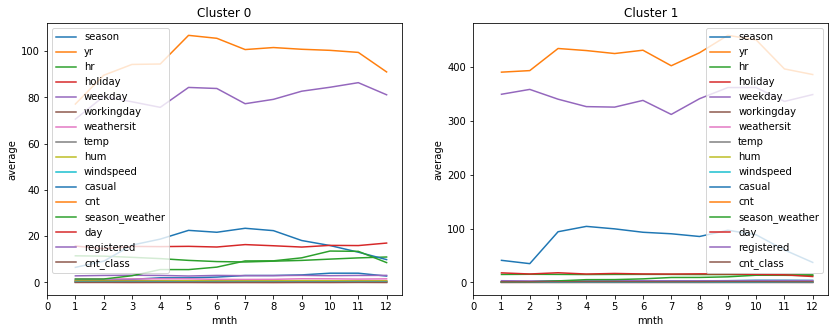

In [20]:
# graficamos la agrupación anterior en ambos clusters.
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
month_ticks = np.arange(13)

for i in range(2):
    df_group.ix[i].plot(ax=ax[i], xticks=month_ticks)
    ax[i].set_title('Cluster {0}'.format(i))
    ax[i].set_ylabel('average')

#### Comentarios
Haciendo uso de groupBy podemos agrupar por cluster y añadiendo otras variables podemos realizar distintas agrupaciones, lo que nos permite llevar a cabo otros análisis y otras formas de graficar los datos obtenidos.

Observamos como las variables "cnt" y "registered", están muy separadas del resto con medias de valores más dispares, y como en cada uno de los clusters toman valores claramente distintos. Esto de nuevo nos permite corroborar que son las variables más determinantes, a través de las cuales los diferentes métodos llevan a cabo la separación por clusters.

Por otro lado, podemos concluir que no hay gran diferencia al aplicar K-means trás PCA, que a lo obtenido en anteriores ejercicios de la práctica. Esto se debe a que PCA tiene como objetivo la compresión de la T de características, mientras que la agrupación tiene como objetivo la compresión de los N datos de puntos.

In [21]:
# hacemos samples del dataset para reducir su tamaño y no tener problemas con el método silhouette_score y poder
# ver según esta medida score el número óptimo de clusters.
sample_1 = X.sample(frac=0.2, replace=True)
sample_1.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
4160,3,0,6,6,0,1,1,2,0.62,0.78,0.1642,4,94,10,27,90.0,0,0
3443,2,0,5,9,0,6,0,1,0.64,0.73,0.2537,61,177,5,28,116.0,0,0
15344,4,1,10,13,0,6,0,2,0.64,0.57,0.5224,310,710,14,6,400.0,2,1
11852,2,1,5,1,0,1,1,2,0.60,0.60,0.2836,5,11,6,14,6.0,0,0
16782,4,1,12,1,0,5,1,2,0.24,0.70,0.1940,2,28,14,7,26.0,0,0


In [22]:
sample_2 = X.sample(frac=0.2, replace=True)
sample_2.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,cnt,season_weather,day,registered,cnt_class,Cluster
12872,3,1,6,13,0,1,1,1,0.72,0.51,0.2985,79,260,9,25,181.0,1,1
3023,2,0,5,21,0,2,1,1,0.54,0.52,0.0000,30,203,5,10,173.0,0,0
15453,4,1,10,2,0,4,1,1,0.42,0.50,0.1343,4,11,13,11,7.0,0,0
2513,2,0,4,15,0,2,1,2,0.54,0.65,0.1642,44,127,6,19,83.0,0,0
1971,2,0,3,23,0,0,0,1,0.26,0.44,0.1940,3,19,5,27,16.0,0,0


In [23]:
# cálculo de componentes principales con PCA para sample 1
pca = PCA(n_components = 2)
pca.fit(sample_1)

reduced_data = pca.transform(sample_1)

reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

In [24]:
# cálculo de componentes principales con PCA para sample 2
pca = PCA(n_components = 2)
pca.fit(sample_2)

reduced_data_2 = pca.transform(sample_2)

reduced_data_2 = pd.DataFrame(reduced_data_2, columns = ['Dimension 1', 'Dimension 2'])

In [25]:
# calcular el score con distinto número de clusters para ver el número óptimo de los mismos.
def KMeans_score(x_kmeans, n = None):
    clusterer = KMeans(n_clusters = n, random_state = 0).fit(x_kmeans)

    preds = clusterer.predict(x_kmeans)

    centers = clusterer.cluster_centers_

    score = silhouette_score(x_kmeans, preds)
    print ("Número de clusters: ", n)
    print ("Score: ", round(score, 4))
    print ("")
    return score

In [26]:
# Calcular scores de distintos números de clusters para el sample 1
for i in range(2, 6):
    KMeans_score(reduced_data, n = i)

Número de clusters:  2
Score:  0.6041

Número de clusters:  3
Score:  0.5687

Número de clusters:  4
Score:  0.5435

Número de clusters:  5
Score:  0.5366



In [27]:
# Calcular scores de distintos números de clusters para el sample 2
for i in range(2, 6):
    KMeans_score(reduced_data_2, n = i)

Número de clusters:  2
Score:  0.6205

Número de clusters:  3
Score:  0.574

Número de clusters:  4
Score:  0.5444

Número de clusters:  5
Score:  0.5331



#### Comentarios

Despues de hacer el estudio en los dos samples sobre el dataset de bicis, podemos ver como el máximo score para cada uno de ellos es cuando el número de cluster es 2. Luego conseguimos verificar los resultados obtenidos en el ejericio 1.